# 1. IMPORT FILES & LIBRARIES

In [1]:
# run data_loader to load the traffic dataset
from IPython.utils.io import capture_output

with capture_output() as captured:
    %run data_loader.ipynb


In [2]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical functions
from scipy.stats import mannwhitneyu
from scipy import stats
import math

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Data standardisation
from sklearn.preprocessing import StandardScaler

# import config file
from config import Config

# 2. PRIMARY DATA ANALYSIS

1. Data is studied for two freeways 5 and 55.
2. Only HV and ML type of lanes record traffic data completely.
3. On our focus region: Freeway 5 contains 24 sensors and 55 contains 17 sensors.
4. No negative total flow.
5. Traffic flow depends on the number of lanes while average speed does not.

## 2.1 About Freeways: Traffic Data

In [3]:
print ('No. of Freeways:', len(df['freeway'].unique()))
freeways = sorted(df['freeway'].unique())
print ('Freeways:', freeways)

No. of Freeways: 2
Freeways: [5, 55]


## 2.2 About Lanes: Traffic Data

In [4]:
df.groupby(['lane_type']).agg({'station':'nunique'})

,station
lane_type,
HV,22
ML,19


In [5]:
filtered_meta_df.groupby(['lanes','type']).agg({'freeway_id':'nunique'})

,,freeway_id
lanes,type,
1,HV,22
3,ML,5
4,ML,6
5,ML,6
6,ML,2


## 2.3 About Stations: Traffic Data

In [6]:
df.groupby(['freeway']).agg({'station':'nunique'})

,station
freeway,
5,24
55,17


## 2.4 Basic Analysis

In [7]:
df.groupby(['lanes']).agg({'avg_speed':'mean', 'total_flow':['mean','max','min']})

avg_speed  total_flow         
            mean        mean  max min
lanes                                
1      61.616993   53.750810  198   0
3       61.04571  198.943840  518   0
4       62.78616  292.855716  740   0
5      61.898462  405.346345  875  11
6      60.156015  482.141465  915  25

# 3. EXPLORATORY DATA ANALYSIS

## 3.1 KEY VARIABLES

1. Total flow is skewed with most values <200.
2. Avg. speed mostly around 65mph.
3. Avg. occupancy <0.2 for most times.
4. Total flow and avg. occupancy highly correlated, while avg. speed and avg. occupancy highly negatively correlated.

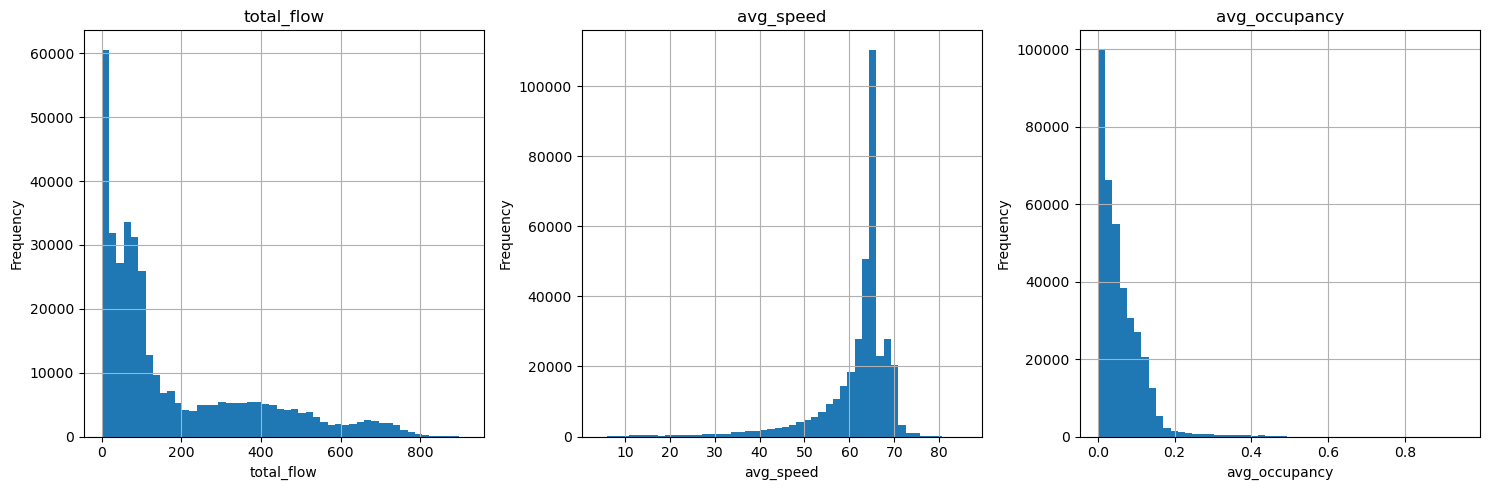

In [8]:
def create_side_by_side_histograms(df, columns, bins=50, figsize=(15, 5)):
    """
    Creates side-by-side histograms for the specified columns in a DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): A list of column names to plot.
    bins (int, optional): The number of bins for the histograms. Defaults to 100.
    figsize (tuple, optional): The figure size. Defaults to (15, 5).
    """

    num_cols = len(columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=figsize)

    for i, col in enumerate(columns):
        df[col].hist(bins=bins, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

columns_to_plot = ['total_flow', 'avg_speed', 'avg_occupancy']
create_side_by_side_histograms(df, columns_to_plot)


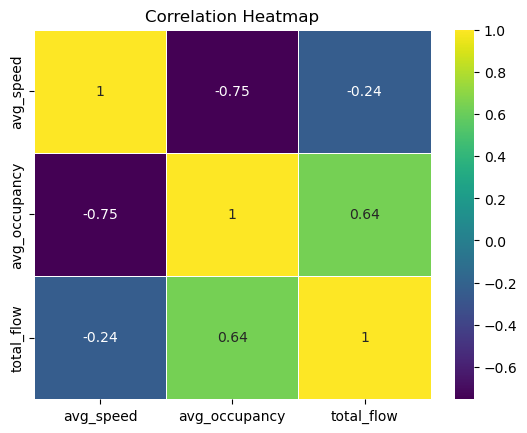

In [9]:
correlation_matrix = df[['avg_speed', 'avg_occupancy', 'total_flow']].corr()

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## 3.2 ANALYSIS ON TEMPORAL COLUMNS

1. Sunday has lowest traffic. 
2. Traffic flow depends on DOW and hour of the day.
3. Hourly traffic rise a morning and drops a night.
4. Similar trends on all roads for i) weekdays ii) weekends

### DOW effect: Traffic Data

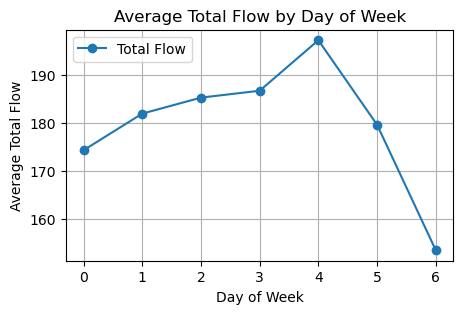

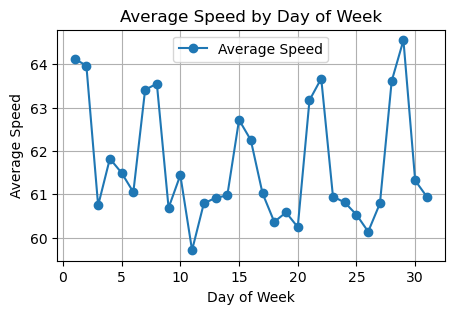

In [10]:
# Day of Week Analysis
# Separate plots for total flow and average speed
plt.figure(figsize=(5, 3))

df_by_dow = df.groupby('dow')['total_flow'].mean()
plt.plot(df_by_dow.index, df_by_dow.values, marker='o', label='Total Flow')
plt.xlabel('Day of Week')
plt.ylabel('Average Total Flow')
plt.title('Average Total Flow by Day of Week')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(5, 3))

df_by_dow = df.groupby('day')['avg_speed'].mean()
plt.plot(df_by_dow.index, df_by_dow.values, marker='o', label='Average Speed')
plt.xlabel('Day of Week')
plt.ylabel('Average Speed')
plt.title('Average Speed by Day of Week')
plt.grid(True)
plt.legend()
plt.show()

### Time of Day Effect: Traffic Data

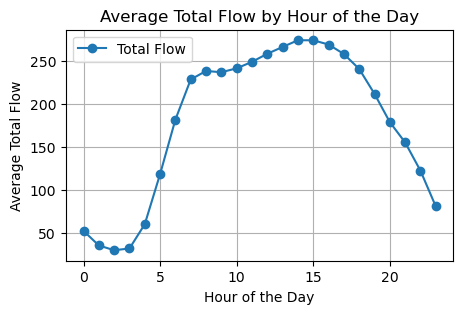

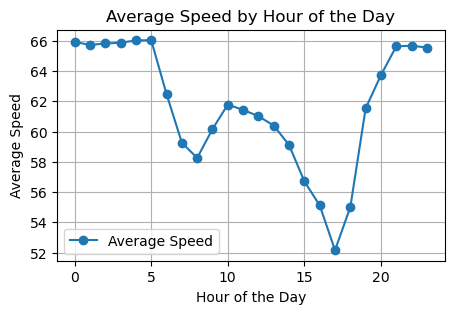

In [11]:
# Hour Analysis (considering all days together)

plt.figure(figsize=(5, 3))
df_by_hour_speed = df.groupby('hour')['total_flow'].mean()
plt.plot(df_by_hour_speed.index, df_by_hour_speed.values, marker='o', label='Total Flow')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Total Flow')
plt.title('Average Total Flow by Hour of the Day')
plt.grid(True)
plt.legend()
plt.show()

df_by_hour_speed = df.groupby('hour')['avg_speed'].mean()
plt.figure(figsize=(5, 3))
plt.plot(df_by_hour_speed.index, df_by_hour_speed.values, marker='o', label='Average Speed')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed')
plt.title('Average Speed by Hour of the Day')
plt.grid(True)
plt.legend()
plt.show()

### DOW and Time of Day Effect (Together): Traffic Data

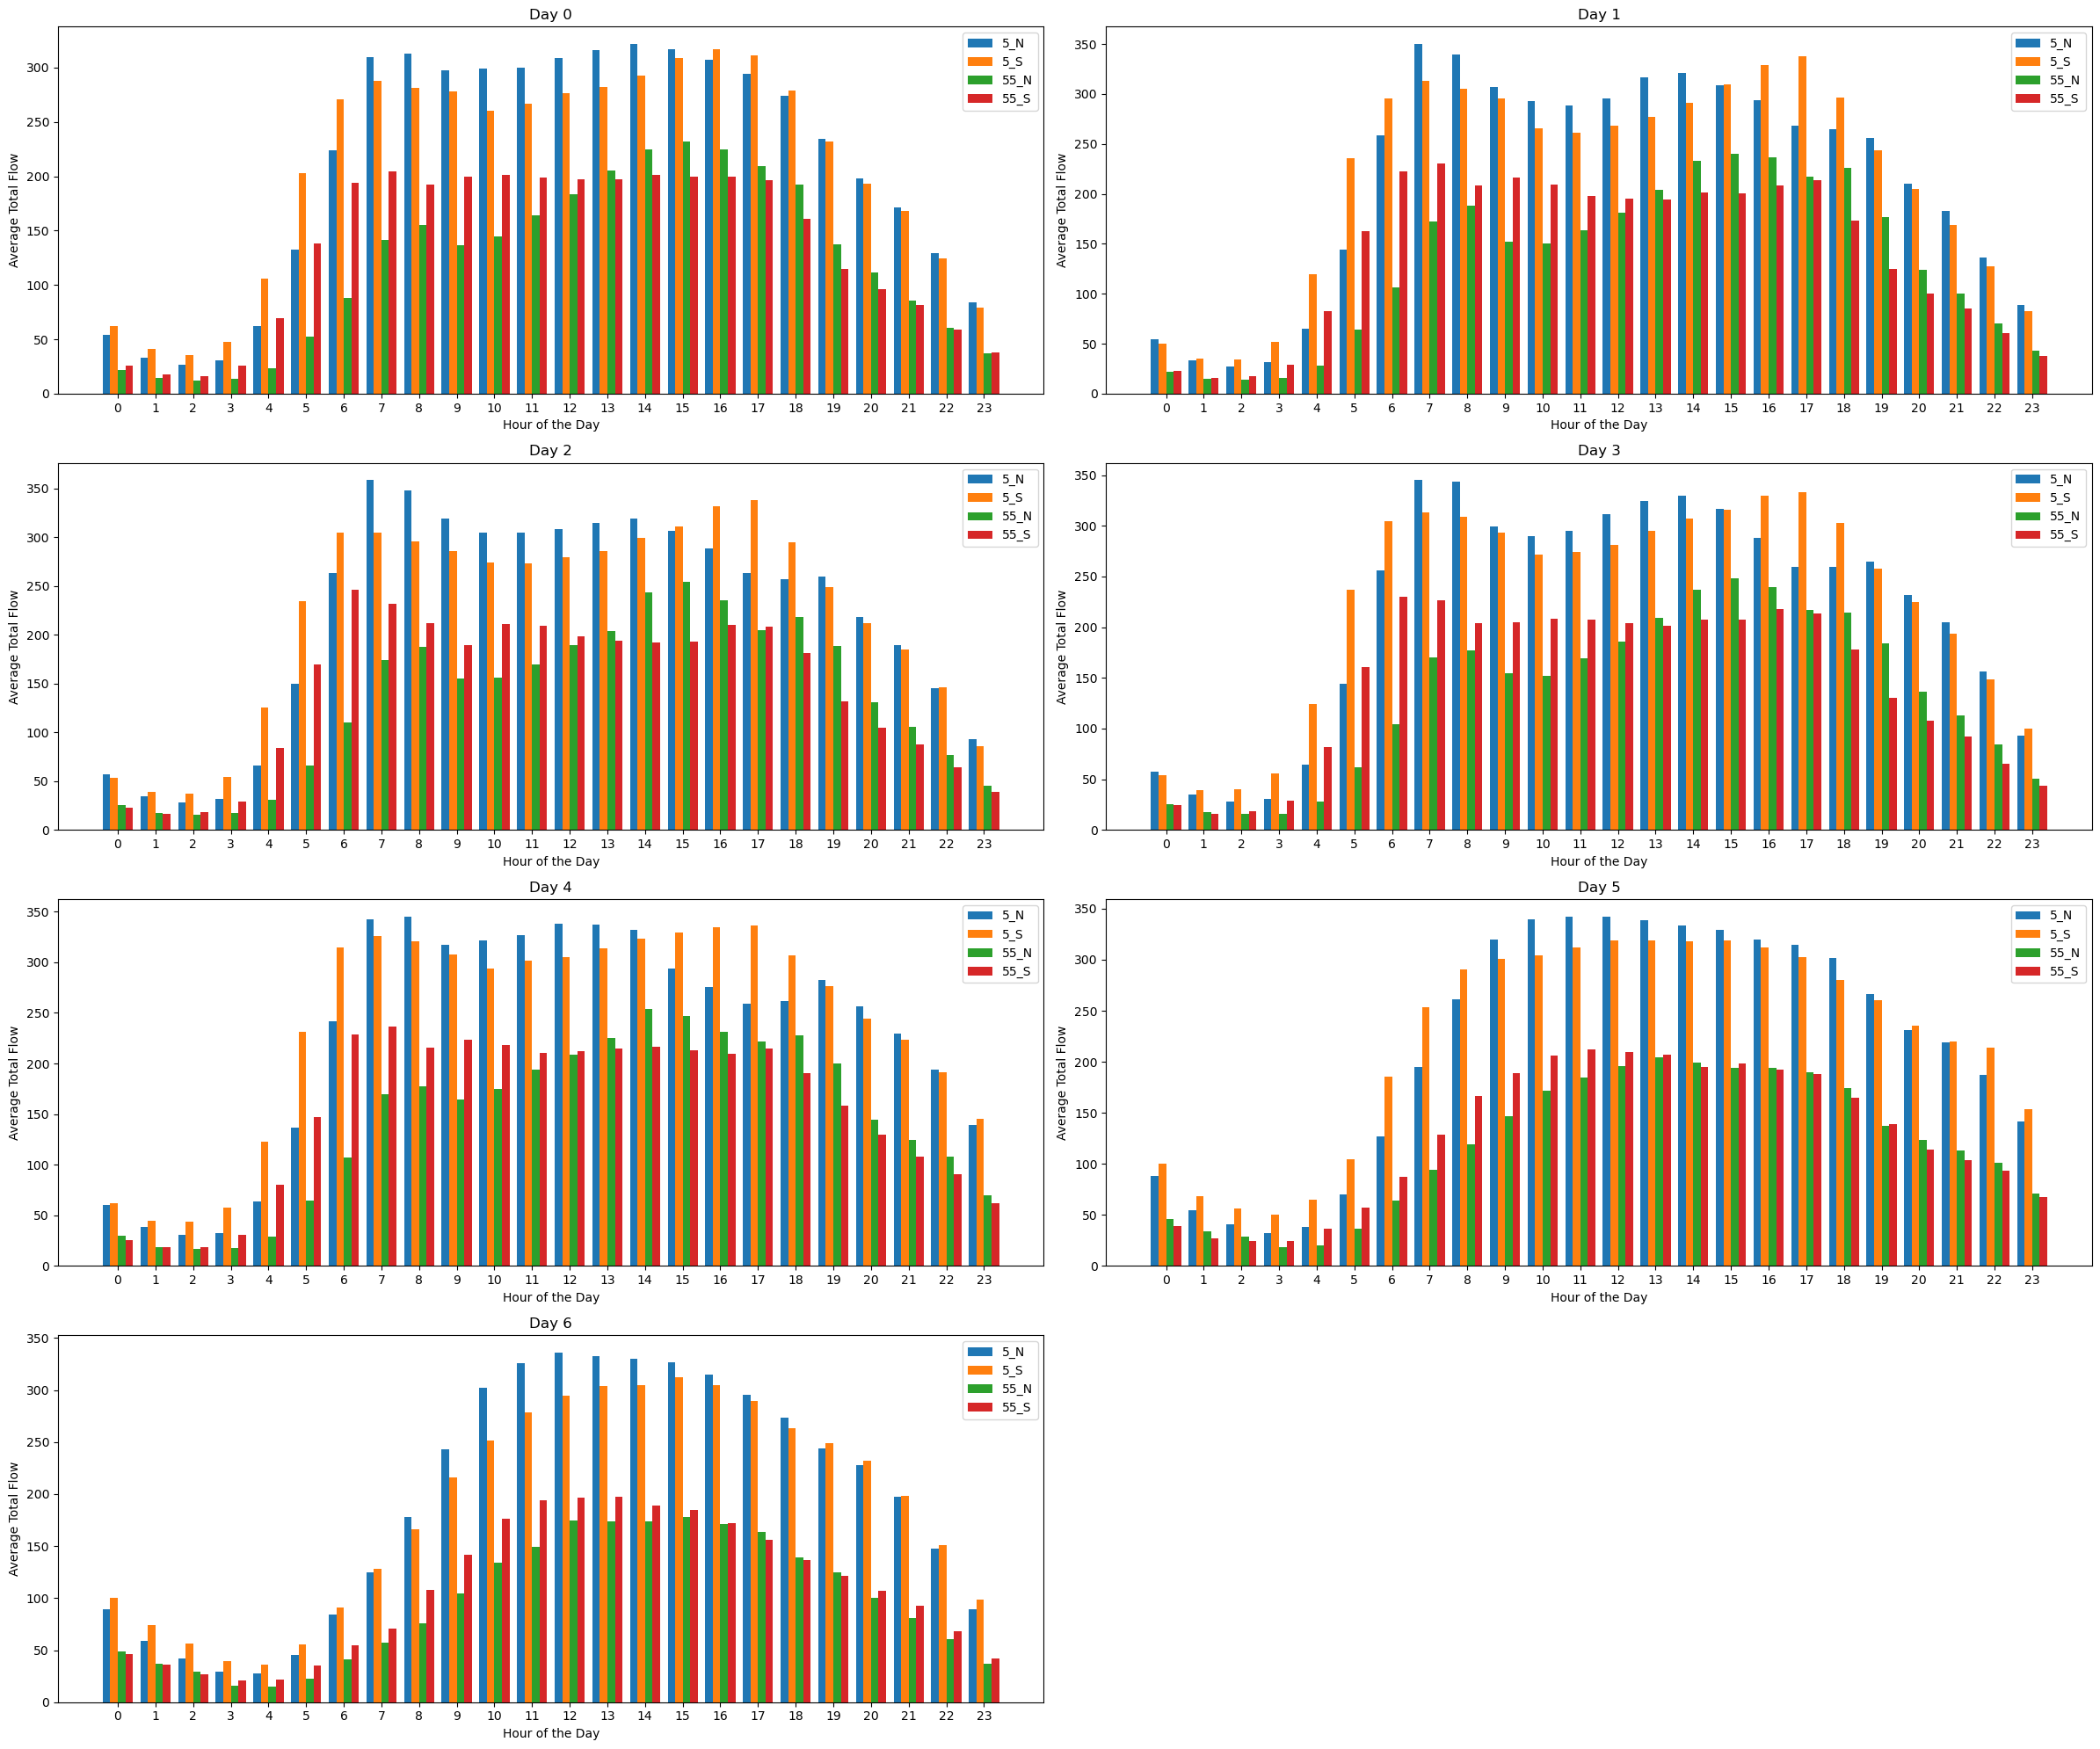

In [12]:
# Group the data and calculate average total_flow
grouped = df.groupby(['dow', 'hour', 'freeway', 'direction_of_travel'])['total_flow'].mean().reset_index()

# Create a unique identifier for each freeway-direction combination
grouped['freeway_direction'] = grouped['freeway'].astype(str) + '_' + grouped['direction_of_travel']

# Parameters
days = grouped['dow'].nunique()
graphs_per_row = 2  # You can change this value to adjust graphs per row

# Calculate rows needed
rows = math.ceil(days / graphs_per_row)

# Create subplots
fig, axs = plt.subplots(rows, graphs_per_row, figsize=(12*graphs_per_row, 5*rows))
axs = axs.flatten() if days > 1 else [axs]

for day in range(days):
    day_data = grouped[grouped['dow'] == day]
    
    freeway_directions = day_data['freeway_direction'].unique()
    x = day_data['hour'].unique()
    width = 0.2
    
    for i, fd in enumerate(freeway_directions):
        fd_data = day_data[day_data['freeway_direction'] == fd]
        axs[day].bar(x + i*width, fd_data['total_flow'], width, label=fd)
    
    axs[day].set_xlabel('Hour of the Day')
    axs[day].set_ylabel('Average Total Flow')
    axs[day].set_title(f'Day {day}')
    axs[day].set_xticks(x + width * 1.5)
    axs[day].set_xticklabels(x)
    axs[day].legend()

# Remove any unused subplots
for i in range(days, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

## 3.3 ANALYSIS ON LAG FEATURES

1. 0-30 mins total flow lag is highly correlated.
2. lag 2016 (-7days) is 2nd most correlated.
3. These 2 can act as potential recent and historical timeframes respectively

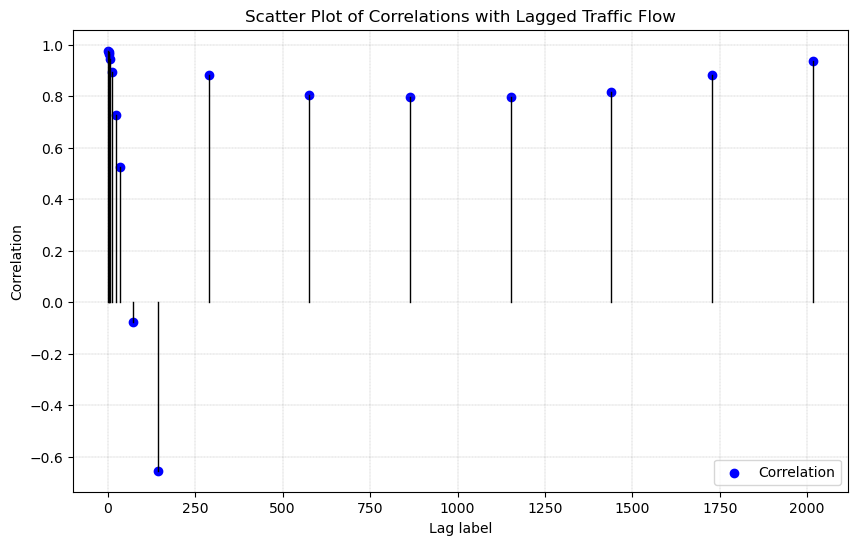

In [13]:
df_cpy = df.copy()
df_cpy = df_cpy.sort_values(by = ['station','iso_timestamp'])
# # List of lags in minutes
lags = {
    '-5min': 1,
    '-10min': 2,
    '-15min': 3,
    '-30min': 6,
    '-60min': 12,
    '-2hours': 24,
    '-3hours': 36,
    '-6hours': 72,
    '-12hours': 144,
    '-1day': 288,
    '-2days': 288*2,
    '-3days': 288*3,
    '-4days': 288*4,
    '-5days': 288*5,
    '-6days': 288*6,
    '-7days': 2016
}

lags = sorted(list(lags.values()))

# Prepare an empty DataFrame for correlation results
correlations = pd.DataFrame()

# # Loop over each station to compute lag features and correlations
for station in df_cpy['station'].unique():
    station_df = df_cpy[df_cpy['station'] == station].copy()
    
    # Create lag features
    col_labels = ['total_flow']
    for lag in lags:
        station_df[str(lag)] = station_df['total_flow'].shift(lag)
        col_labels.append(str(lag))
    
# Calculate correlations with the current total_flow
    corr = station_df[col_labels].corr()#.loc['total_flow'].filter(like='total_flow_lag_')
    correlations = pd.concat([correlations, corr['total_flow']])

corr_data = correlations.groupby(correlations.index).mean()
corr_data = corr_data.drop(['total_flow'])
corr_data.columns = ['correlation']
corr_data.index = corr_data.index.astype(int)
corr_data = corr_data.sort_index()

plt.figure(figsize=(10, 6))
plt.scatter(corr_data.index, corr_data['correlation'], color='blue', label='Correlation')

# Add vertical lines from x-axis to the points
for x, y in zip(corr_data.index, corr_data['correlation']):
    plt.plot([x, x], [0, y], color='black', linestyle='-', linewidth=1)

# # Labels and title
plt.xlabel('Lag label')
plt.ylabel('Correlation')
plt.title('Scatter Plot of Correlations with Lagged Traffic Flow')
plt.legend()

# # Show plot
plt.grid(True, color='gray', linestyle='--', linewidth=0.2)
plt.show()


## 3.4. ANALYSIS ON WEATHER

1. Traffic flow is more affected by visibility than rain (avg speed decreases and avg occupancy increases).

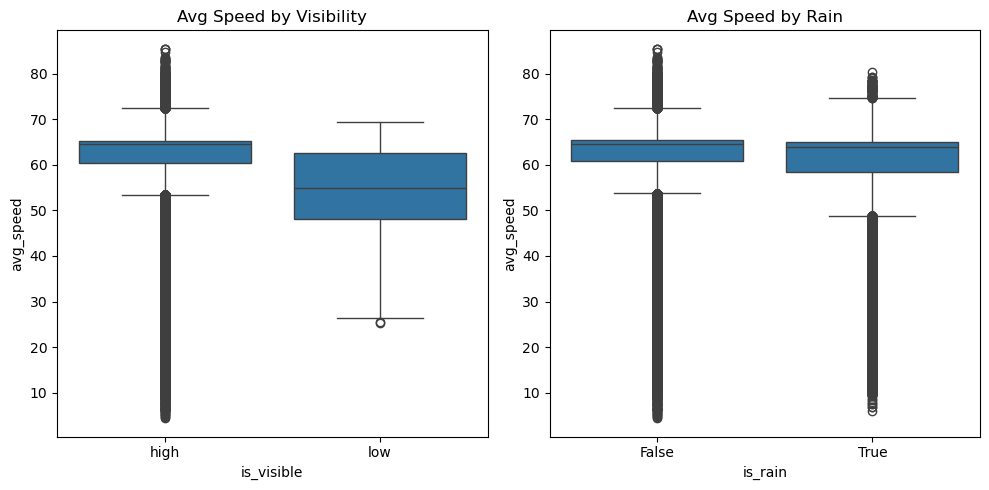

In [14]:
my_df = df.copy()
visibility_th = 3 # just to check if low visibility effects
my_df['is_visible'] = (my_df['visibility']>visibility_th).astype(int)
my_df['is_visible'] = my_df['is_visible'].map({0:'low', 1:'high'})
my_df['is_rain'] = my_df['conditions'].str.contains('Rain')

plt.figure(figsize=(10, 5))

# Box plot for avg_speed by is_visible
plt.subplot(1, 2, 1)
sns.boxplot(x='is_visible', y='avg_speed', data=my_df)
plt.title('Avg Speed by Visibility')

# Box plot for avg_speed by is_visible
plt.subplot(1, 2, 2)
sns.boxplot(x='is_rain', y='avg_speed', data=my_df)
plt.title('Avg Speed by Rain')

plt.tight_layout()
plt.show()

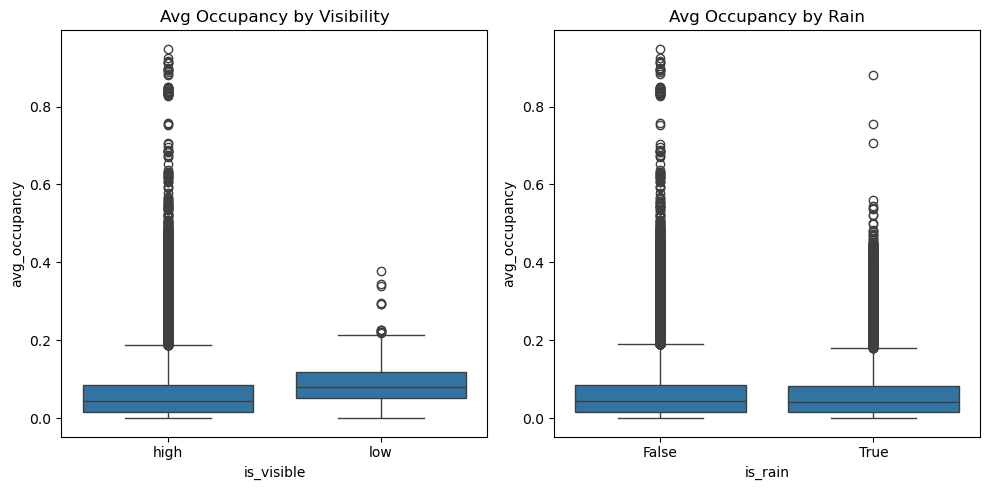

In [15]:
my_df = df.copy()
visibility_th = 3 # just to check if low visibility effects
my_df['is_visible'] = (my_df['visibility']>visibility_th).astype(int)
my_df['is_visible'] = my_df['is_visible'].map({0:'low', 1:'high'})
my_df['is_rain'] = my_df['conditions'].str.contains('Rain')

plt.figure(figsize=(10, 5))

# Box plot for avg_occupancy by is_visible
plt.subplot(1, 2, 1)
sns.boxplot(x='is_visible', y='avg_occupancy', data=my_df)
plt.title('Avg Occupancy by Visibility')

# Box plot for avg_occupancy by is_visible
plt.subplot(1, 2, 2)
sns.boxplot(x='is_rain', y='avg_occupancy', data=my_df)
plt.title('Avg Occupancy by Rain')

plt.tight_layout()
plt.show()

## 3.5 ANALYSIS ON INCIDENT (HYPOTHESIS TESTING)

### Hypothesis Testing (Ha: Avg. Speed (dec.) & Occupancy (inc.) & Total Traffic Flow (inc.) changes when Incident is Nearby
For Speed:

Null hypothesis (H0): There is no difference in avg_speed between incident and non-incident cases.
Alternative hypothesis (H1): avg_speed decreases when an incident is nearby.

For Occupancy:

Null hypothesis (H0): There is no difference in avg_occupancy between incident and non-incident cases.
Alternative hypothesis (H1): avg_occupancy increases when an incident is nearby.

For Total Flow:

Null hypothesis (H0): There is no difference in total_flow between incident and non-incident cases.
Alternative hypothesis (H1): total_flow increases when an incident is nearby.

### Check for Normality

In [16]:
# Perform visual checks using histograms and Q-Q plots
def visualize_distribution(data, title):
    plt.figure(figsize=(10.5, 3))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {title}')
    
    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {title}')
    
    plt.show()


incident_nearby = df[df['incident_nearby'] == 1].copy()
incident_not_nearby = df[df['incident_nearby'] == 0].copy()

### 1. Avg. Speed

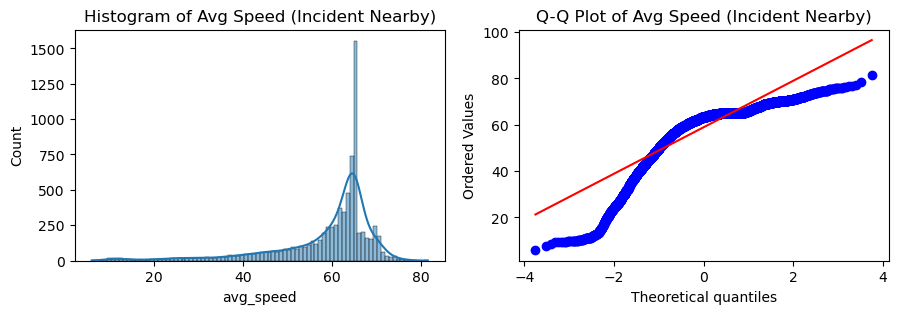

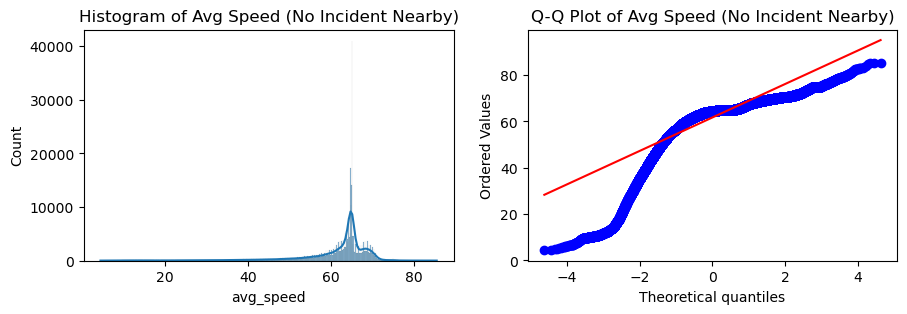

In [17]:
visualize_distribution(incident_nearby['avg_speed'].astype(float), 'Avg Speed (Incident Nearby)')
visualize_distribution(incident_not_nearby['avg_speed'].astype(float), 'Avg Speed (No Incident Nearby)')

### 2. Avg. Occupancy

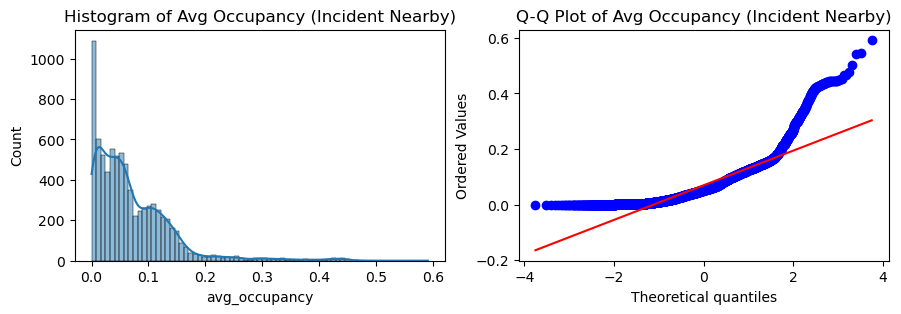

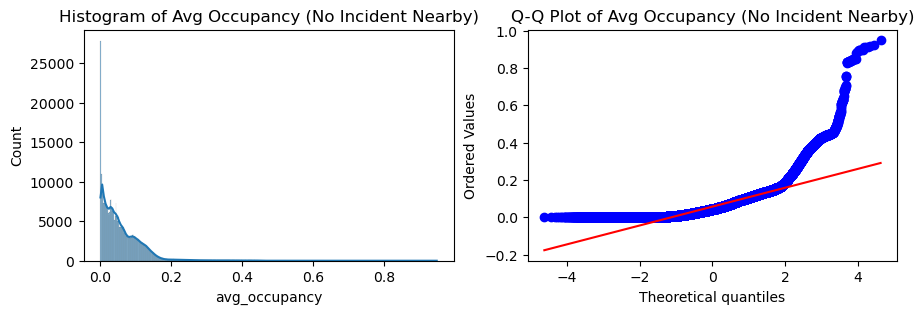

In [18]:
visualize_distribution(incident_nearby['avg_occupancy'].astype(float), 'Avg Occupancy (Incident Nearby)')
visualize_distribution(incident_not_nearby['avg_occupancy'].astype(float), 'Avg Occupancy (No Incident Nearby)')

### 3. Total Speed

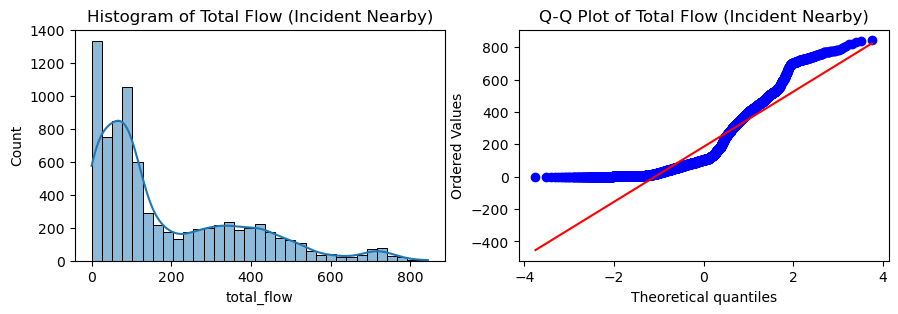

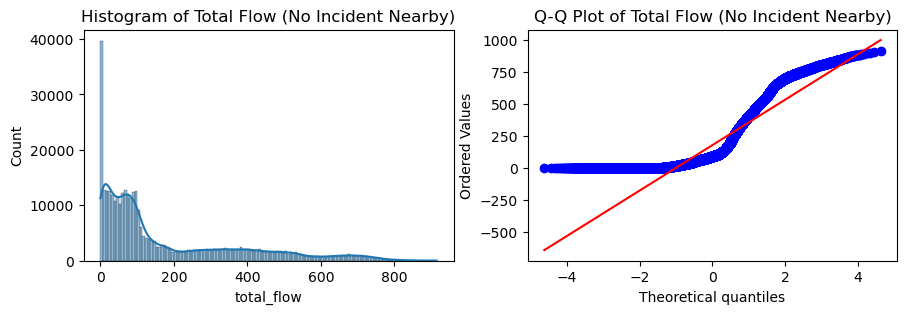

In [19]:
visualize_distribution(incident_nearby['total_flow'].astype(float), 'Total Flow (Incident Nearby)')
visualize_distribution(incident_not_nearby['total_flow'].astype(float), 'Total Flow (No Incident Nearby)')

### Apply Hypothesis Test

In [20]:
# Alternative hypothesis: avg_speed decreases when incident nearby
u_stat_speed, p_value_speed = mannwhitneyu(
    incident_nearby['avg_speed'].astype(float), 
    incident_not_nearby['avg_speed'].astype(float), 
    alternative='less'  # "less" means expect the first group to have lower values
)

# Perform one-tailed Mann-Whitney U test for avg_occupancy
# Alternative hypothesis: avg_occupancy increases when incident nearby
u_stat_occupancy, p_value_occupancy = mannwhitneyu(
    incident_nearby['avg_occupancy'].astype(float), 
    incident_not_nearby['avg_occupancy'].astype(float), 
    alternative='greater'  # "greater" means expect the first group to have higher values
) 

u_stat_flow, p_value_flow = mannwhitneyu(
    incident_nearby['total_flow'].astype(float), 
    incident_not_nearby['total_flow'].astype(float), 
    alternative='greater'  # "greater" means expect the first group to have higher values
) #avg_occupancy

# Print results
print(f"Avg Speed Mann-Whitney U Test (one-tailed): U-statistic = {u_stat_speed:.3f}, p-value = {p_value_speed:.3f}")
print(f"Avg Occupancy Mann-Whitney U Test (one-tailed): U-statistic = {u_stat_occupancy:.3f}, p-value = {p_value_occupancy:.3f}")
print(f"Total Flow Mann-Whitney U Test (one-tailed): U-statistic = {u_stat_flow:.3f}, p-value = {p_value_flow:.3f}")

# Interpretation
alpha = 0.05  # significance level
print("\nInterpretation:")
print("Avg Speed:", "Significant decrease" if p_value_speed < alpha else "No significant decrease")
print("Avg Occupancy:", "Significant increase" if p_value_occupancy < alpha else "No significant increase")
print("Total Flow:", "Significant increase" if p_value_flow < alpha else "No significant increase")

Avg Speed Mann-Whitney U Test (one-tailed): U-statistic = 1196876278.500, p-value = 0.000
Avg Occupancy Mann-Whitney U Test (one-tailed): U-statistic = 1564466251.000, p-value = 0.000
Total Flow Mann-Whitney U Test (one-tailed): U-statistic = 1496235794.500, p-value = 0.000

Interpretation:
Avg Speed: Significant decrease
Avg Occupancy: Significant increase
Total Flow: Significant increase


## 3.6 ANALYSIS ON SPATIAL DEPENDENCY (HIERARCHICAL CLUSTERING)

1. Modelling on spatial dependency is important. Nearby stations has similar traffic flow.

### Draw a Dendogram

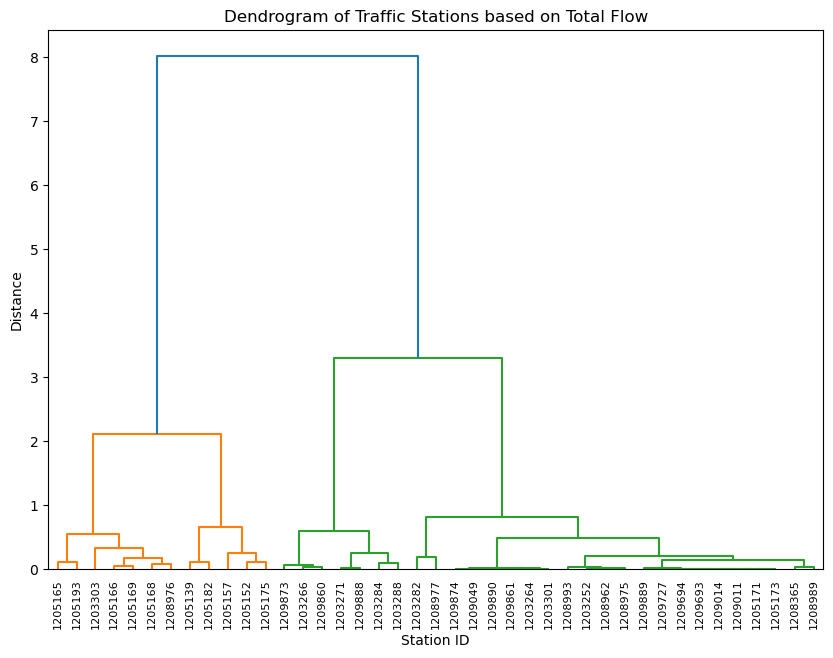

In [21]:
# Aggregate data by station (sum total_flow for each station over the entire period)
df_agg = df.groupby('station')['total_flow'].sum().reset_index()

# Step 2: Normalize the Data
scaler = StandardScaler()
df_agg['total_flow_normalized'] = scaler.fit_transform(df_agg[['total_flow']])

# Step 3: Calculate Distance Matrix
# Create a matrix of distances between stations based on total_flow
linked = linkage(df_agg[['total_flow_normalized']], method='ward')

# Step 4: Plot the Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df_agg['station'].values, leaf_rotation=90)
plt.title('Dendrogram of Traffic Stations based on Total Flow')
plt.xlabel('Station ID')
plt.ylabel('Distance')
plt.show()


### Check how far are the stations in the cluster

In [22]:
# Initialize a list to track clusters
clusters = {i: [station] for i, station in enumerate(df_agg['station'])}

# Initialize a list to store results
cluster_results = []

# Process the linkage matrix to get clusters of stations
for i, (cluster1, cluster2, distance, num_observations) in enumerate(linked):
    # Get the stations in the two clusters being merged
    stations_cluster1 = clusters[int(cluster1)]
    stations_cluster2 = clusters[int(cluster2)]
    
    # Create the new cluster by merging these two
    new_cluster = stations_cluster1 + stations_cluster2
    
    # Add this to our results
    cluster_results.append({
        'cluster1_stations': stations_cluster1,
        'cluster2_stations': stations_cluster2,
        'distance': distance,
        'num_observations': num_observations
    })
    
    # Update the clusters dictionary with the new cluster
    clusters[len(df_agg) + i] = new_cluster

# Convert the cluster results to a DataFrame
linkage_df = pd.DataFrame(cluster_results)

# Display the resulting DataFrame
display(linkage_df.sort_values(by=['num_observations','distance']).head(5))

,cluster1_stations,cluster2_stations,distance,num_observations
0,[1205171],[1205173],0.000000,2.0
6,[1209049],[1209890],0.000199,2.0
7,[1203264],[1203301],0.002454,2.0
10,[1208962],[1208975],0.005623,2.0
12,[1203271],[1209888],0.011160,2.0


In [23]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula to calculate the great-circle distance
    dlat = lat2 - lat1  # Difference in latitude
    dlon = lon2 - lon1  # Difference in longitude
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))

    # Radius of Earth in miles (mean radius)
    r = 3958.8

    # Calculate the distance in miles and return it
    return c * r

# Sort the DataFrame and select the top 5 rows
linkage_df = linkage_df.sort_values(by=['num_observations', 'distance']).head(5)

# Iterate over each row in the sorted DataFrame
for i, row in linkage_df.iterrows():
    # Check if both clusters contain only one station each
    if len(row['cluster1_stations']) == 1 and len(row['cluster2_stations']) == 1:
        
        # Retrieve latitude and longitude for the first station in cluster 1
        lat1, lon1 = (df[df['station'] == row['cluster1_stations'][0]][['latitude', 'longitude']].drop_duplicates().values[0])
        
        # Retrieve latitude and longitude for the first station in cluster 2
        lat2, lon2 = (df[df['station'] == row['cluster2_stations'][0]][['latitude', 'longitude']].drop_duplicates().values[0])
        
        # Calculate the distance between the two stations using the Haversine formula
        distance = haversine_distance(lat1, lon1, lat2, lon2)
        
        # Print the calculated distance rounded to 2 decimal places
        print('Distance:', round(distance, 2), 'miles')


Distance: 0.02 miles
Distance: 0.34 miles
Distance: 0.69 miles
Distance: 0.21 miles
Distance: 0.01 miles


## 3.7 ANALYSIS ON LANES

1. Traffic flow increases and no. of lane increases 

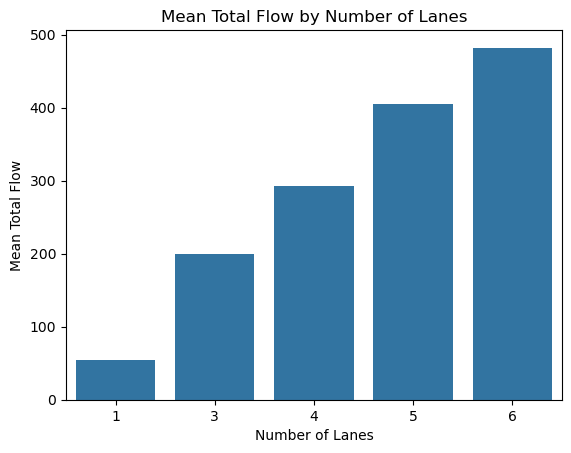

In [24]:
mean_flow_by_lanes = df.groupby(['lanes']).agg({'total_flow':'mean'})

# Create a bar plot
sns.barplot(x=mean_flow_by_lanes.index, y='total_flow', data=mean_flow_by_lanes)
plt.xlabel('Number of Lanes')
plt.ylabel('Mean Total Flow')
plt.title('Mean Total Flow by Number of Lanes')
plt.show()

Range of Traffic Flow per Lane: 0 - 198


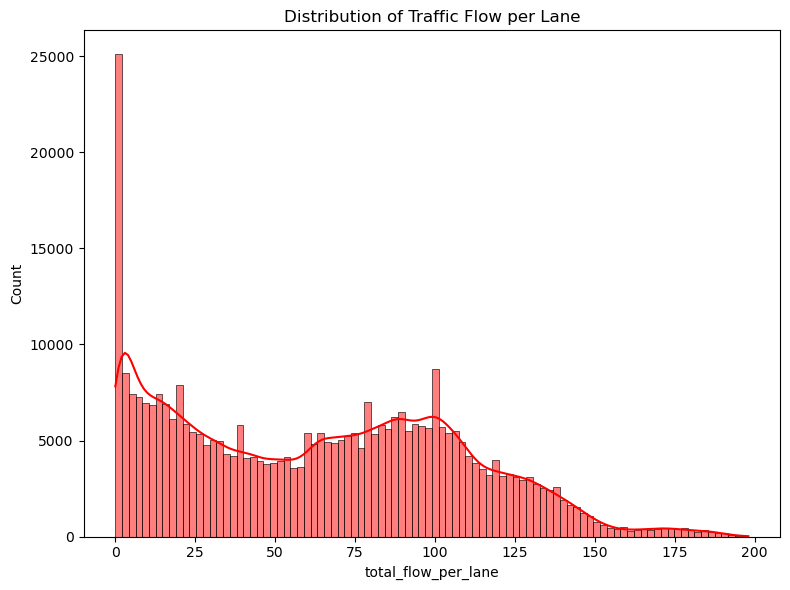

In [25]:
df_cpy = df.copy()

df_cpy['total_flow_per_lane'] = df_cpy['total_flow']/df_cpy['lanes']

print ('Range of Traffic Flow per Lane:', int(np.min(df_cpy['total_flow_per_lane'])), '-', int(np.max(df_cpy['total_flow_per_lane'])))
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

sns.histplot(df_cpy['total_flow_per_lane'], kde=True, color='red')
plt.title('Distribution of Traffic Flow per Lane')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
